In [68]:
#Define Constante
DIR = "/content/drive/MyDrive/Colab Notebooks/UPM/PRDL/EDA/"

#importation
import statsmodels.api as sm
import numpy as np
from pandas.plotting import scatter_matrix
from google.colab import drive
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn import linear_model, neighbors, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [123]:
def importData():
  drive.mount("/content/drive")
  
  #Change directory
  os.chdir(DIR)

  # Read Clinical Data
  OSA_Clinical_df = pd.read_csv("OSA_DB_UPM_Clinical.csv",sep=';',na_values=['-1'])
  OSA_Clinical_df=OSA_Clinical_df.dropna()

  # Now Read Demographical Information
  OSA_Demo_df = pd.read_csv("OSA_DB_UPM_Age_Gender.csv",na_values=['-1'])
  OSA_Demo_df=OSA_Demo_df.dropna()

  # JOIN OSA_Demo_df and OSA_Clinical_df
  OSA_df = pd.merge(OSA_Clinical_df, OSA_Demo_df, on='ID', how='inner')

  OSA_df['ID'] = OSA_df['ID'].astype('str')
  OSA_df = OSA_df.set_index('ID')

  #Only treat male gender
  df_OSA_male = OSA_df.loc[OSA_df['Gender'] == 0]

  conditions = [
      (df_OSA_male['IAH'] <= 10),
      (df_OSA_male['IAH'] > 10) & (df_OSA_male['IAH'] < 30),
      (df_OSA_male['IAH'] >= 30)
      ]

  # create a list of the values we want to assign for each condition
  values = ['Healthy', 'Mild', 'Severe']

  # create a new column and use np.select to assign values to it using our lists as arguments
  # NOTE: we use select() from numpy
  df_OSA_male['OSA'] = np.select(conditions, values)

  #Remove Mild class
  df_OSA_male_extreme = df_OSA_male.loc[df_OSA_male['OSA'] != 'Mild']

  #Creating BMI column
  df_OSA_male_extreme['BMI'] =  df_OSA_male_extreme['Weight'] / (df_OSA_male_extreme['Height']/100.0)**2
  df_OSA_male_extreme['Y'] = (df_OSA_male_extreme['OSA'] == 'Severe').astype(int)
  return df_OSA_male_extreme

##Now We are going to explore the data (EDA)

In [124]:
df = importData()
df.groupby('OSA').describe()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

IAH                                      ...    Y                    
         count       mean        std   min     25%  ...  min  25%  50%  75%  max
OSA                                                 ...                         
Healthy  132.0   5.046970   3.065305   0.0   2.600  ...  0.0  0.0  0.0  0.0  0.0
Severe   128.0  45.053594  14.186095  30.0  34.225  ...  1.0  1.0  1.0  1.0  1.0

[2 rows x 64 columns]

OSA
Healthy    AxesSubplot(0.125,0.125;0.775x0.755)
Severe     AxesSubplot(0.125,0.125;0.775x0.755)
Name: BMI, dtype: object

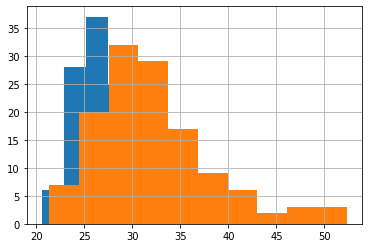

In [125]:
df.groupby('OSA')['BMI'].hist()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


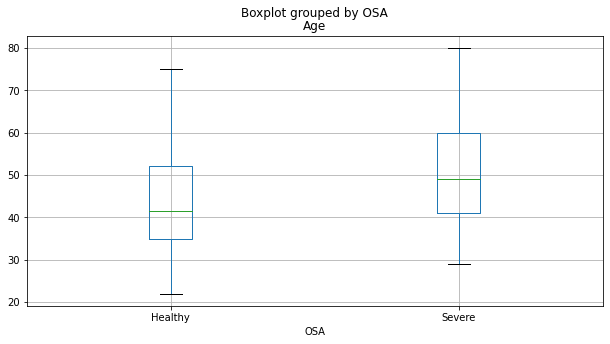

In [127]:
df.boxplot(column='Age', by='OSA', figsize=(10 ,5))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


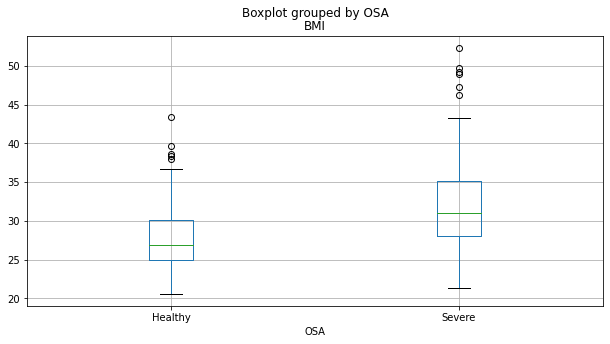

In [56]:
df.boxplot(column='BMI', by='OSA', figsize=(10 ,5))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


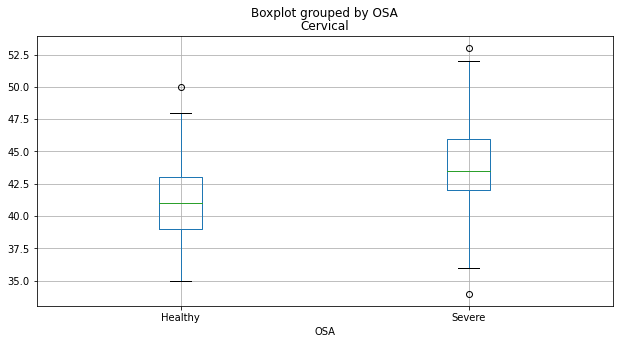

In [57]:
df.boxplot(column='Cervical', by='OSA', figsize=(10 ,5))

## T-test and Mann Whitneyu's test to mesure the dicriminant power of parameters

In [134]:
from scipy import stats
for column in ['Age', 'BMI', 'Cervical']:
  group1 = df.where(df.OSA== 'Healthy').dropna()[column]
  group2 = df.where(df.OSA== 'Severe').dropna()[column]
  t_test_p_value = stats.ttest_ind(group1,group2)[1]
  mannWhitney_p_value = stats.mannwhitneyu(group1,group2)[1]
  print('Variable :', column,', Same mean p-value =', t_test_p_value,
        'Same distribution p-value =', mannWhitney_p_value)


Variable : Age , Same mean p-value = 4.7561243590568463e-07 Same distribution p-value = 6.038495596210771e-07
Variable : BMI , Same mean p-value = 6.320437870715736e-11 Same distribution p-value = 2.258215034895147e-11
Variable : Cervical , Same mean p-value = 3.5060457312045025e-11 Same distribution p-value = 2.6099508668554335e-11


### Individual linear regression on Age, BMI and Cervical

In [128]:
def logistic_regression_test(predictor):
  target = 'Y'

  # Define the model
  model = sm.Logit(y, df[predictor]).fit()

  predictions = model.predict(df[predictor])
  predictions  = (predictions > 0.5).astype(int)
  acc = accuracy_score(y, predictions)
  print("Logistic regression on :", predictor)
  print(model.summary())
  print("\nAccuracy :", acc, "\n\n")

In [129]:
#Define features and output
predictors = ['Age', 'BMI', 'Cervical']
for predictor in predictors:
  logistic_regression_test(predictor)

Optimization terminated successfully.
         Current function value: 0.691239
         Iterations 3
Logistic regression on : Age
                           Logit Regression Results                           
Dep. Variable:                    OSA   No. Observations:                  260
Model:                          Logit   Df Residuals:                      259
Method:                           MLE   Df Model:                            0
Date:                Fri, 26 Nov 2021   Pseudo R-squ.:                0.002582
Time:                        16:08:08   Log-Likelihood:                -179.72
converged:                       True   LL-Null:                       -180.19
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0025      0.003      0.995      0.320      -0.002       0.008


### Multiple linear regression on Age, Weight, Height and Cervical

In [132]:
#Define features and output
predictors = ['BMI', 'Cervical', 'Age']
target = 'Y'
# Define the model
model = sm.OLS(df[target], df[predictors]).fit()
print(model.summary())
predictions = model.predict(df[predictors])
predictions  = (predictions > 0.5).astype(int)
acc = accuracy_score(y, predictions)
print("Accuracy : ", acc)

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.583
Model:                            OLS   Adj. R-squared (uncentered):              0.578
Method:                 Least Squares   F-statistic:                              119.8
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                    1.47e-48
Time:                        16:10:00   Log-Likelihood:                         -163.06
No. Observations:                 260   AIC:                                      332.1
Df Residuals:                     257   BIC:                                      342.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Try to fit with a ML model

### Function for split the data into training and testing dataset

In [4]:
def splitData(dataSet):
  # Splitting into train and test sets

  # Generate the training set.  Set random_state to be able to replicate results.
  train = dataSet.sample(frac=0.8, random_state=1)

  # Select anything not in the training set and put it in the testing set.
  test = dataSet.loc[~dataSet.index.isin(train.index)]

  # Print the shapes of both sets.
  #print(train.shape)
  #print(test.shape)
  
  return train, test

### Training function:

In [5]:
def model_training(model, features, output):
  # Fit the model to the training data.
  Trained_model=model.fit(features, output)
  return Trained_model

### Testing fonction

In [6]:
def model_testing(model, features, output):
  ### Predicting Error

  # Generate our predictions for the test set.
  predictions = model.predict(features)

  # Compute accuracy between our test predictions and the actual values.
  acc=accuracy_score(predictions, output)       
  print('Accuracy: ', acc)

  # Plot confusion matrix
  print(confusion_matrix(predictions, output))
  #plt.show()

### Automated process to test a model

In [58]:
def training_process(model, predictors, target, data):
  print("Model : ", type(model))
  print('Predictor : ', predictors)
  print("Target : ", target)
  #Split Date into Training and testing dataset, Train and Test the model on those
  train, test = splitData(data)
  #Training the model
  model = model_training(model, train[predictors], train[target])

  #Test it on both dataset
  print("Training dataset : ")
  model_testing(model, train[predictors], train[target])
  print("Training dataset : ")
  model_testing(model, test[predictors], test[target])

### Logistic Regression

In [136]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'Y'

# Define the model
model = linear_model.LogisticRegression()
training_process(model, predictors, target, df)

Model :  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  Y
Training dataset : 
Accuracy:  0.7307692307692307
[[79 29]
 [27 73]]
Training dataset : 
Accuracy:  0.6346153846153846
[[19 12]
 [ 7 14]]


In [138]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'Y'

# Define the model
model = svm.SVC()
training_process(model, predictors, target, df)

Model :  <class 'sklearn.svm._classes.SVC'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  OSA
Training dataset : 
Accuracy:  0.7163461538461539
[[67 20]
 [39 82]]
Training dataset : 
Accuracy:  0.6923076923076923
[[19  9]
 [ 7 17]]


In [140]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'Y'

# Define the model
model = DecisionTreeClassifier(max_depth=15)
training_process(model, predictors, target, df)

Model :  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  Y
Training dataset : 
Accuracy:  1.0
[[106   0]
 [  0 102]]
Training dataset : 
Accuracy:  0.7115384615384616
[[20  9]
 [ 6 17]]


In [171]:
#Define features and output
predictors = ['BMI', 'Age', 'Cervical']
target = 'Y'

# Define the model
model = neighbors.KNeighborsClassifier(n_neighbors = 10, weights='uniform')
training_process(model, predictors, target, df)

Model :  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Predictor :  ['BMI', 'Age', 'Cervical']
Target :  Y
Training dataset : 
Accuracy:  0.7355769230769231
[[79 28]
 [27 74]]
Training dataset : 
Accuracy:  0.7307692307692307
[[21  9]
 [ 5 17]]


In [165]:
from xgboost import XGBClassifier
#Xboosting
predictors = ['BMI', 'Age', 'Cervical', 'Weight', 'Height']
target = 'Y'

# Define the model
model = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=100)
training_process(model, predictors, target, df)

Model :  <class 'xgboost.sklearn.XGBClassifier'>
Predictor :  ['BMI', 'Age', 'Cervical', 'Weight', 'Height']
Target :  Y
Training dataset : 
Accuracy:  0.8990384615384616
[[95 10]
 [11 92]]
Training dataset : 
Accuracy:  0.6730769230769231
[[19 10]
 [ 7 16]]
